### 필수 library 설치
- PyTorch (1.5.1)
- torchaudio


In [ ]:
!pip install torch
!pip install torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Code (WaveGlow)

#### Reference 
- WaveGlow (implemented by NVIDIA): https://github.com/NVIDIA/waveglow
- 딥러닝을 활용한 음성합성(1) (T-academy): https://tacademy.skplanet.com/live/player/onlineLectureDetail.action?seq=184

In [ ]:
import torch
import torch.nn as nn
import torchaudio
from torch import optim
from torch.utils.data import DataLoader
from torch.distributions.normal import Normal
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import librosa
import os
import argparse
import time, datetime
import json
import gc
from math import pi, log


print('Import 완료')

Import 완료


### 0. GPU 체크

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

if not use_cuda:
    print('Edit - Notebook settings 에서 GPU로 변경해주세요.')

else:
    print('GPU 사용 준비가 완료되었습니다.')


GPU 사용 준비가 완료되었습니다.


### 1. Dataset (LJ Speech) 다운로드

This is a public domain speech dataset consisting of 13,100 short audio clips of a single speaker reading passages from 7 non-fiction books. A transcription is provided for each clip. Clips vary in length from 1 to 10 seconds and have a total length of approximately 24 hours.

Link: https://keithito.com/LJ-Speech-Dataset/

In [ ]:
LJSpeech_url = 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2'
train_dataset = torchaudio.datasets.LJSPEECH("", url=LJSpeech_url, download=True)

print('Download 완료')

  0%|          | 0.00/2.56G [00:00<?, ?B/s]

Download 완료


### 2. Dataset 전처리

훈련을 위한 데이터셋 전처리를 진행합니다.

LJ speech 음성 데이터에서 mel-spectrogram을 얻은 뒤, 이를 적당한 간격(15872 samples)으로 잘라내어 훈련 데이터 셋을 구성합니다.

LJ speech의 sample rate은 22.05kHz로 15872 samples는 약 0.72초를 모델링하는 것과 같습니다.

Mel-spectrogram은 dynamic_range_compression 함수를 통해 크기를 재조절합니다.

In [ ]:
hop_length = 256
max_steps = 15872

class Collate():
    def __init__(self):
        self.wav_to_mel = torchaudio.transforms.MelSpectrogram(sample_rate=22050, n_mels=80, win_length=1024, hop_length=hop_length, f_min=0.0, f_max=8000.0, n_fft=1024)

    def __call__(self, batch):
        # batch: N_batch * [wav, sample_rate, text, text_normalized]

        x_batch = []
        c_batch = []
        for idx in range(len(batch)):
            x = batch[idx][0].squeeze()
            c = self.wav_to_mel(x)
            c = self.dynamic_range_compression(c)
            
            pad = (x.shape[0] // hop_length + 1) * hop_length - x.shape[0]
            pad_l = pad // 2
            pad_r = pad // 2 + pad % 2

            # zero pad for quantized signal
            x = np.pad(x, (pad_l, pad_r), mode="constant", constant_values=0.0)
            x = torch.tensor(x)

            max_time_frames = max_steps // hop_length
            s = np.random.randint(0, c.shape[1] - max_time_frames)
            ts = s * hop_length
            x = x[ts:ts + hop_length * max_time_frames]
            c = c[:,s:s + max_time_frames]
            
            x_batch.append(x)
            c_batch.append(c)

        x_batch = torch.stack(x_batch)
        c_batch = torch.stack(c_batch)

        return x_batch, c_batch

    def dynamic_range_compression(self, x, C=1, clip_val=1e-5):
        return torch.log(torch.clamp(x, min=clip_val) * C)

collate_fn = Collate()
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=False, collate_fn=collate_fn)
x_batch, c_batch = next(iter(train_loader))

print('audio batch shape:', x_batch.shape)
print('mel batch shape:', c_batch.shape)
print('Data 전처리 완료')

audio batch shape: torch.Size([8, 15872])
mel batch shape: torch.Size([8, 80, 62])
Data 전처리 완료


### 3. WaveGlow 구현

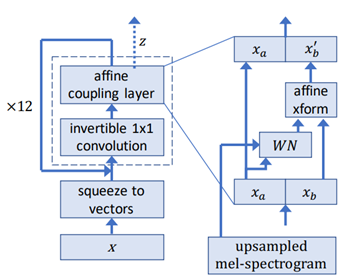

#### 3.1 Upsample conv

ConvTranspose1d로 간단히 구현합니다.

in_channels와 out_channels는 mel-spectrogram의 주파수 축 차원과 동일하게 80으로 설정합니다.

mel-spectrogram의 frame 길이는 audio를 temporal axis로 256배 축소한 것으로 설정되어 있습니다.

따라서 audio의 길이와 동일하게 늘려주기 위하여 stride를 256로 설정하겠습니다.

또한 주변 frame 값들도 고려하기 위하여 kernel_size를 256보다 큰 1024로 설정하겠습니다.


In [57]:
import torch
conv = torch.nn.Conv2d(1, 1, kernel_size=2,stride=1)
torch.nn.init.ones_(conv.weight)
torch.nn.init.zeros_(conv.bias)

Parameter containing:
tensor([0.], requires_grad=True)

In [42]:
x = torch.arange(16, dtype=torch.float32).reshape(1,1,4,4)
print(x)

out = conv(x)
print(out)

tensor([[[[ 0.,  1.,  2.,  3.],
          [ 4.,  5.,  6.,  7.],
          [ 8.,  9., 10., 11.],
          [12., 13., 14., 15.]]]])
tensor([[[[10., 14., 18.],
          [26., 30., 34.],
          [42., 46., 50.]]]], grad_fn=<ConvolutionBackward0>)


In [44]:
conv = torch.nn.ConvTranspose2d(1, 1, kernel_size=2,stride=1)
torch.nn.init.ones_(conv.weight)
torch.nn.init.zeros_(conv.bias)

Parameter containing:
tensor([0.], requires_grad=True)

In [45]:
x = torch.arange(9, dtype=torch.float32).reshape(1,1,3,3)
print(x)

out = conv(x)
print(out)

tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]])
tensor([[[[ 0.,  1.,  3.,  2.],
          [ 3.,  8., 12.,  7.],
          [ 9., 20., 24., 13.],
          [ 6., 13., 15.,  8.]]]], grad_fn=<ConvolutionBackward0>)


In [56]:
x = torch.tensor([[1,2],
                  [3,4]], dtype=torch.float32)

out = torch.linalg.det(x)
print(out)
x_i = x.inverse()
print(x_i)
print(x.matmul(x_i))

tensor(-2.)
tensor([[-2.0000,  1.0000],
        [ 1.5000, -0.5000]])
tensor([[1., 0.],
        [0., 1.]])


In [59]:
x = torch.arange(16, dtype=torch.float32).reshape(1,1,4,4)
conv = torch.nn.Conv2d(1, 1, kernel_size=2,stride=2)
torch.nn.init.ones_(conv.weight)
torch.nn.init.zeros_(conv.bias)
out = conv(x)
print(out)

tensor([[[[10., 18.],
          [42., 50.]]]], grad_fn=<ConvolutionBackward0>)


In [61]:
x = torch.arange(4, dtype=torch.float32).reshape(1,1,2,2)
conv = torch.nn.ConvTranspose2d(1, 1, kernel_size=2,stride=2)
torch.nn.init.ones_(conv.weight)
torch.nn.init.zeros_(conv.bias)
out = conv(x)
print(out)

tensor([[[[0., 0., 1., 1.],
          [0., 0., 1., 1.],
          [2., 2., 3., 3.],
          [2., 2., 3., 3.]]]], grad_fn=<ConvolutionBackward0>)


In [63]:
x = torch.arange(9, dtype=torch.float32).reshape(1,1,3,3)
conv = torch.nn.ConvTranspose2d(1, 1, kernel_size=2,stride=1,padding=(1,1))
torch.nn.init.ones_(conv.weight)
torch.nn.init.zeros_(conv.bias)
out = conv(x)
print(out)

tensor([[[[ 8., 12.],
          [20., 24.]]]], grad_fn=<ConvolutionBackward0>)


In [ ]:
class UpsampleConv(nn.Module):
    def __init__(self, n_mel_channels=80):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose1d(n_mel_channels, n_mel_channels, kernel_size=1024, stride=256)

    def forward(self, spect):
        spect = self.upsample(spect)
        return spect

#### 3.2 Invertible 1x1 Convolution


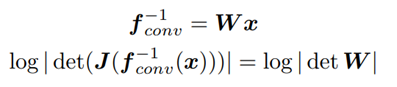


1x1 convolution을 구현합니다.

Changing ordering을 대신하는 역할을 수행할 것이므로 bias가 없는 layer를 선언합니다.

이때 최초 weight 값은 orthonormal basis로 구성합니다.

채널을 섞을 때 발생하는 log-determinant는 log|detW| 이며, 이를 매 프레임에 대해서 동일하게 적용하므로 최종적인 log-determinant는 batch_size * frame_length * log|detW| 가 됩니다.

역변환은 W의 역행렬을 구하여 진행합니다.

In [ ]:
class Invertible1x1Conv(torch.nn.Module):
    def __init__(self, c):
        super().__init__()
        self.conv = torch.nn.Conv1d(c, c, kernel_size=1, stride=1, padding=0, bias=False)
        W = torch.qr(torch.FloatTensor(c, c).normal_())[0]
        if torch.det(W) < 0:
            W[:,0] = -1*W[:,0]
        W = W.view(c, c, 1)
        self.conv.weight.data = W

    def forward(self, x, log_det_sum):
        # shape
        z = self.conv(x)
        
        B, _, T = x.size()
        W = self.conv.weight.squeeze()
        log_det_W = B * T * torch.logdet(W)
        log_det_sum = log_det_sum + log_det_W

        return z, log_det_sum

    def reverse(self, z):
        W = self.conv.weight.squeeze()
        W_inverse = W.float().inverse()
        W_inverse = Variable(W_inverse[..., None])
        self.W_inverse = W_inverse
        x = F.conv1d(z, self.W_inverse, bias=None, stride=1, padding=0)
        
        return x

#### 3.3. Non-causal WaveNet

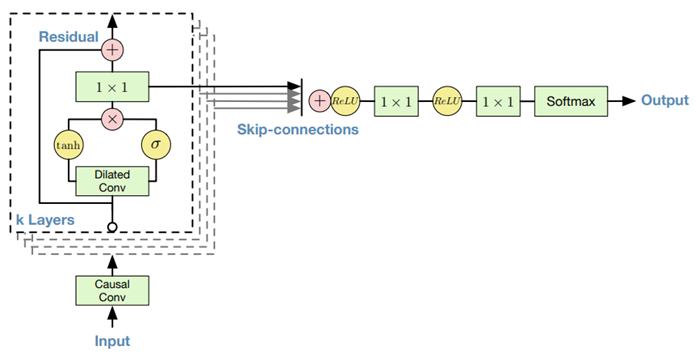

Non-causal WaveNet을 구현합니다.

Mel-spectrogram를 local condition으로 하여 affine coupling layer에서 사용될 log_s, t 값을 계산합니다.

Receptive field를 넓게 설정하기 위하여 layer를 쌓으면서 dilation을 2의 배수로 증가시킵니다.

Non-linearity로 tanh - gate unit을 사용합니다.

In [ ]:
class WN(nn.Module):
    """
    This is the WaveNet like layer for the affine coupling.  The primary difference
    from WaveNet is the convolutions need not be causal.  There is also no dilation
    size reset.  The dilation only doubles on each layer
    """
    def __init__(self, in_channels, cin_channels, n_layers=8, n_channels=128,
                 kernel_size=3):
        super(WN, self).__init__()
        assert(kernel_size % 2 == 1)
        assert(n_channels % 2 == 0)
        self.n_layers = n_layers
        self.n_channels = n_channels
        self.in_layers = torch.nn.ModuleList()
        self.res_skip_layers = torch.nn.ModuleList()

        start = torch.nn.Conv1d(in_channels, n_channels, 1)
        start = torch.nn.utils.weight_norm(start, name='weight')
        self.start = start

        # Initializing last layer to 0 makes the affine coupling layers
        # do nothing at first.  This helps with training stability
        end = torch.nn.Conv1d(n_channels, 2*in_channels, 1)
        end.weight.data.zero_()
        end.bias.data.zero_()
        self.end = end

        cond_layer = torch.nn.Conv1d(cin_channels, 2*n_channels*n_layers, 1)
        self.cond_layer = torch.nn.utils.weight_norm(cond_layer, name='weight')

        for i in range(n_layers):
            dilation = 2 ** i
            padding = int((kernel_size*dilation - dilation)/2)
            in_layer = torch.nn.Conv1d(n_channels, 2*n_channels, kernel_size,
                                       dilation=dilation, padding=padding)
            in_layer = torch.nn.utils.weight_norm(in_layer, name='weight')
            self.in_layers.append(in_layer)

            # last one is not necessary
            if i < n_layers - 1:
                res_skip_channels = 2*n_channels
            else:
                res_skip_channels = n_channels
            res_skip_layer = torch.nn.Conv1d(n_channels, res_skip_channels, 1)
            res_skip_layer = torch.nn.utils.weight_norm(res_skip_layer, name='weight')
            self.res_skip_layers.append(res_skip_layer)

    def forward(self, audio, spect):
        audio = self.start(audio)
        output = torch.zeros_like(audio)
        n_channels_tensor = torch.IntTensor([self.n_channels])

        spect = self.cond_layer(spect)

        for i in range(self.n_layers):
            spect_offset = i*2*self.n_channels
            acts = self.fused_add_tanh_sigmoid_multiply(
                self.in_layers[i](audio),
                spect[:,spect_offset:spect_offset+2*self.n_channels,:],
                n_channels_tensor)

            res_skip_acts = self.res_skip_layers[i](acts)
            if i < self.n_layers - 1:
                audio = audio + res_skip_acts[:,:self.n_channels,:]
                output = output + res_skip_acts[:,self.n_channels:,:]
            else:
                output = output + res_skip_acts

        return self.end(output).chunk(2,1)


    def fused_add_tanh_sigmoid_multiply(self, input_a, input_b, n_channels):
        n_channels_int = n_channels[0]
        in_act = input_a+input_b
        t_act = torch.tanh(in_act[:, :n_channels_int, :])
        s_act = torch.sigmoid(in_act[:, n_channels_int:, :])
        acts = t_act * s_act
        return acts

#### 3.4 Affine coupling layer

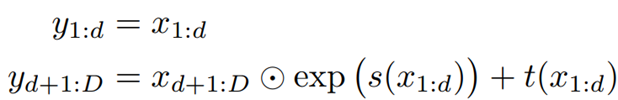


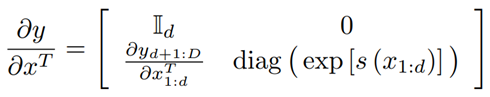

Affine coupling layer를 구현합니다.

input의 절반(x_a)은 변환을 하지 않고, 나머지 절반(x_b)은 affine transform을 적용합니다.

이때, s와 t는 x_a를 non-causal WaveNet을 통과시켜 얻습니다.

구현의 편의상 non-causal WaveNet의 출력을 log_s, t로 생각하겠습니다.

Jacobian matrix를 고려하면 determinant는 대각 성분의 곱이 되고, 

최종적인 log-determinant는 sum(log_s)가 됩니다.

In [ ]:
class AffineCouplingLayer(nn.Module):
    def __init__(self, in_channels, cin_channels):
        super().__init__()
        self.WN = WN(in_channels, cin_channels)

    def forward(self, x, c, log_det_sum):

        x_a, x_b = x.chunk(2,1)
        log_s, t = self.WN(x_a, c)
        x_b = torch.exp(log_s) * x_b + t
        log_det_sum = log_det_sum + log_s.sum()
        z = torch.cat((x_a, x_b), dim=1)

        return z, c, log_det_sum

    def reverse(self, z, c):
        z_a, z_b = z.chunk(2,1)
        log_s, t = self.WN(z_a, c)
        z_b = torch.exp(-log_s) * (z_b - t)

        x = torch.cat((z_a, z_b), dim=1)

        return x, c


#### 3. WaveGlow 최종 모델

In [ ]:
class WaveGlow(torch.nn.Module):
    def __init__(self, n_mel_channels=80, n_flows=12, n_group=8, n_early_every=4,
                 n_early_size=2):
        super(WaveGlow, self).__init__()

        self.upsample = UpsampleConv(n_mel_channels)
        assert(n_group % 2 == 0)
        self.n_flows = n_flows
        self.n_group = n_group
        self.n_early_every = n_early_every
        self.n_early_size = n_early_size
        self.coupling_layer = torch.nn.ModuleList()
        self.convinv = torch.nn.ModuleList()
        self.sigma = 1.0

        n_half = int(n_group/2)

        # Set up layers with the right sizes based on how many dimensions
        # have been output already
        n_remaining_channels = n_group
        for k in range(n_flows):
            if k % self.n_early_every == 0 and k > 0:
                n_half = n_half - int(self.n_early_size/2)
                n_remaining_channels = n_remaining_channels - self.n_early_size
            self.convinv.append(Invertible1x1Conv(n_remaining_channels))
            self.coupling_layer.append(AffineCouplingLayer(n_half, n_mel_channels*n_group))
        self.n_remaining_channels = n_remaining_channels  # Useful during inference

    def forward(self, audio, spect):
        audio = audio.squeeze(1)

        #  Upsample spectrogram to size of audio
        spect = self.upsample(spect)
        assert(spect.size(2) >= audio.size(1))
        if spect.size(2) > audio.size(1):
            spect = spect[:, :, :audio.size(1)]

        spect = spect.unfold(2, self.n_group, self.n_group).permute(0, 2, 1, 3)
        spect = spect.contiguous().view(spect.size(0), spect.size(1), -1).permute(0, 2, 1)

        audio = audio.unfold(1, self.n_group, self.n_group).permute(0, 2, 1)

        output_audio = []
        log_det_sum = 0.0

        for k in range(self.n_flows):
            if k % self.n_early_every == 0 and k > 0:
                output_audio.append(audio[:,:self.n_early_size,:])
                audio = audio[:,self.n_early_size:,:]
            audio, log_det_sum = self.convinv[k](audio, log_det_sum)
            audio, spect, log_det_sum = self.coupling_layer[k](audio, spect, log_det_sum)

        output_audio.append(audio)

        z = torch.cat(output_audio,1)

        log_p = 0.5 * (- log(2.0 * pi) - z.pow(2)).sum() / (z.size(0)*z.size(1)*z.size(2))
        log_det = log_det_sum /  (z.size(0)*z.size(1)*z.size(2))
        
        return log_p, log_det

#### 4. 모델 및 옵티마이저 선언

In [ ]:
model = WaveGlow().to(device)
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### 5. 훈련 진행

In [ ]:
iteration = 0

for epoch in range(100):
  print("Epoch: {}".format(epoch))
  for i, (x, c) in enumerate(train_loader):
    start = time.perf_counter()
    model.zero_grad()
    x, c = x.to(device), c.to(device)
    log_p, logdet = model(x, c)
    log_p, logdet = torch.mean(log_p), torch.mean(logdet)

    loss = -(log_p + logdet)
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1.)
    
    optimizer.step()

    duration = time.perf_counter() - start
    print("Iteratoin: {}, [NLL, Log p(z), Log Det]: [{:.4f}, {:.4f}, {:.4f}], {:.2f}s/it".format(iteration, loss.item(), log_p.item(), logdet.item(), duration))
    
    iteration += 1

Epoch: 0
Iteratoin: 0, [NLL, Log p(z), Log Det]: [0.9210, -0.9210, 0.0000], 10.81s/it
Iteratoin: 1, [NLL, Log p(z), Log Det]: [0.7952, -0.9207, 0.1255], 1.46s/it
Iteratoin: 2, [NLL, Log p(z), Log Det]: [0.2561, -1.0066, 0.7505], 1.47s/it
Iteratoin: 3, [NLL, Log p(z), Log Det]: [221.9981, -224.9353, 2.9373], 1.46s/it
Iteratoin: 4, [NLL, Log p(z), Log Det]: [300.9006, -304.3176, 3.4169], 1.46s/it
Iteratoin: 5, [NLL, Log p(z), Log Det]: [172.4814, -175.6836, 3.2021], 1.47s/it
Iteratoin: 6, [NLL, Log p(z), Log Det]: [54.6785, -57.1505, 2.4720], 1.46s/it
Iteratoin: 7, [NLL, Log p(z), Log Det]: [26.4966, -28.6988, 2.2021], 1.47s/it
Iteratoin: 8, [NLL, Log p(z), Log Det]: [2.7188, -4.4485, 1.7298], 1.47s/it
Iteratoin: 9, [NLL, Log p(z), Log Det]: [0.3377, -1.1399, 0.8021], 1.47s/it
Iteratoin: 10, [NLL, Log p(z), Log Det]: [0.2568, -1.0704, 0.8136], 1.48s/it
Iteratoin: 11, [NLL, Log p(z), Log Det]: [-0.0769, -1.6204, 1.6974], 1.48s/it
Iteratoin: 12, [NLL, Log p(z), Log Det]: [-0.4553, -1.7019,

KeyboardInterrupt: ignored